In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.impute import SimpleImputer

def prepare_and_train_model(input_filename, plot_cost_function=False):
    # Read the data
    data = pd.read_csv(input_filename)
    
    # Ensure 'EWJ.Price.Percent.Today' exists
    if 'EWJ.Price.Percent.Today' not in data.columns:
        print("Error: 'EWJ.Price.Percent.Today' column not found. Run previous analysis first.")
        return None, None, None

    # Optional: Plot cost function
    if plot_cost_function:
        plot_lasso_cost_function(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Identify non-numeric columns
    non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns being dropped: {non_numeric_columns}")
    
    # Select only numeric data for imputation and scaling
    numeric_data = data.select_dtypes(include=[np.number])

    # Filter out columns with all missing values
    numeric_data_filtered = numeric_data.dropna(axis=1, how='all')

    # Impute missing values with the column mean (for numeric columns)
    imputer = SimpleImputer(strategy='mean')
    numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data_filtered), columns=numeric_data_filtered.columns)

    
    # Prepare features and target (use only numeric columns)
    X = numeric_data_imputed.drop(['EWJ.Price.Percent.Today'], axis=1)
    y = numeric_data_imputed['EWJ.Price.Percent.Today']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = lasso.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    # Print feature coefficients
    feature_names = X.columns
    coefficients = lasso.coef_
    print("\nFeature Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef}")
    
    return lasso, scaler, X.columns, X_train_scaled, X_test_scaled, y_train, y_test

def get_user_input(feature_columns):
    user_data = {}
    print("\nPlease enter values for the following features:")
    for col in feature_columns:
        while True:
            try:
                value = float(input(f"{col}: "))
                user_data[col] = value
                break
            except ValueError:
                print("Please enter a valid numeric value.") 
    return pd.DataFrame([user_data])
def predict_stock_movement(model, scaler, feature_columns, input_data):
    # Scale the input data
    input_scaled = scaler.transform(input_data)
    
    # Predict percentage change
    predicted_percent_change = model.predict(input_scaled)[0]
    
    # Determine movement direction
    movement = "Up" if predicted_percent_change > 0 else "Down"
    
    return predicted_percent_change, movement

def plot_lasso_cost_function(X_train, X_test, y_train, y_test, alphas=None):
    if alphas is None:
        alphas = np.logspace(-3, 1, 20)
    
    train_mse = []
    test_mse = []
    total_costs = []
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        
        train_pred = lasso.predict(X_train)
        test_pred = lasso.predict(X_test)
        
        train_loss = mean_squared_error(y_train, train_pred)
        test_loss = mean_squared_error(y_test, test_pred)
        
        l1_penalty = alpha * np.sum(np.abs(lasso.coef_))
        total_cost = test_loss + l1_penalty
        
        train_mse.append(train_loss)
        test_mse.append(test_loss)
        total_costs.append(total_cost)
    
    plt.figure(figsize=(12, 6))
    plt.semilogx(alphas, train_mse, label='Train MSE')
    plt.semilogx(alphas, test_mse, label='Test MSE')
    plt.semilogx(alphas, total_costs, label='Total Cost')
    
    plt.xlabel('Alpha (Regularization Strength)')
    plt.ylabel('Cost')
    plt.title('Lasso Cost Function')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(input_filename, output_filename):
    # Train the model
    model, scaler, feature_columns, X_train_scaled, X_test_scaled, y_train, y_test = prepare_and_train_model(input_filename, plot_cost_function=True)
    
    if model is None:
        return
    
    # Get user input
    user_input = get_user_input(feature_columns)
    
    # Predict stock movement
    pred_percent_change, movement = predict_stock_movement(model, scaler, feature_columns, user_input)
    
    # Prepare output with coefficients
    output_df = user_input.copy()
    output_df['Predicted.Percent.Change'] = pred_percent_change
    output_df['Movement.Direction'] = movement
    
    # Add coefficients to the output
    for feature, coef in zip(feature_columns, model.coef_):
        output_df[f'Coefficient.{feature}'] = coef
    
    # Save results
    output_df.to_csv(output_filename, index=False)
    
    print("\nPrediction Results:")
    print(f"Predicted Percentage Change: {pred_percent_change:.4f}%")
    print(f"Movement Direction: {movement}")
    
    # Print coefficients to console as well
    print("\nModel Coefficients:")
    for feature, coef in zip(feature_columns, model.coef_):
        print(f"{feature}: {coef}")

# Example usage
main('input.engineered.csv', 'price_output.csv')



ModuleNotFoundError: No module named 'yfinance'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

def prepare_and_train_model(input_filename, plot_cost_function=False):
    # [Previous data preparation code remains the same]
    
    # Prepare features and target (use only numeric columns)
    X = numeric_data_imputed.drop(['EWJ.Price.Percent.Today'], axis=1)
    y = numeric_data_imputed['EWJ.Price.Percent.Today']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optional: Plot cost function
    if plot_cost_function:
        plot_lasso_cost_function(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Train Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_scaled, y_train)
    
    # [Rest of the existing code remains the same]
    
    return lasso, scaler, X.columns, X_train_scaled, X_test_scaled, y_train, y_test

def plot_lasso_cost_function(X_train, X_test, y_train, y_test, alphas=None):
    if alphas is None:
        alphas = np.logspace(-3, 1, 20)
    
    train_mse = []
    test_mse = []
    total_costs = []
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        
        train_pred = lasso.predict(X_train)
        test_pred = lasso.predict(X_test)
        
        train_loss = mean_squared_error(y_train, train_pred)
        test_loss = mean_squared_error(y_test, test_pred)
        
        l1_penalty = alpha * np.sum(np.abs(lasso.coef_))
        total_cost = test_loss + l1_penalty
        
        train_mse.append(train_loss)
        test_mse.append(test_loss)
        total_costs.append(total_cost)
    
    plt.figure(figsize=(12, 6))
    plt.semilogx(alphas, train_mse, label='Train MSE')
    plt.semilogx(alphas, test_mse, label='Test MSE')
    plt.semilogx(alphas, total_costs, label='Total Cost')
    
    plt.xlabel('Alpha (Regularization Strength)')
    plt.ylabel('Cost')
    plt.title('Lasso Cost Function')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(input_filename, output_filename):
    # Add True to plot the cost function
    model, scaler, feature_columns, X_train_scaled, X_test_scaled, y_train, y_test = prepare_and_train_model(input_filename, plot_cost_function=True)
    
    if model is None:
        return
    

# Example usage
main('input.engineered.csv', 'price_output.csv')

NameError: name 'numeric_data_imputed' is not defined

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.impute import SimpleImputer

def prepare_and_train_model(input_filename):
    # Read the data
    data = pd.read_csv(input_filename)
    
    # Ensure 'EWJ.Price.Percent.Today' exists
    if 'EWJ.Price.Percent.Today' not in data.columns:
        print("Error: 'EWJ.Price.Percent.Today' column not found. Run previous analysis first.")
        return None, None, None
    
    # Identify non-numeric columns
    non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns being dropped: {non_numeric_columns}")
    
    # Select only numeric data for imputation and scaling
    numeric_data = data.select_dtypes(include=[np.number])

    # Filter out columns with all missing values
    numeric_data_filtered = numeric_data.dropna(axis=1, how='all')

    # Impute missing values with the column mean (for numeric columns)
    imputer = SimpleImputer(strategy='mean')
    numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data_filtered), columns=numeric_data_filtered.columns)

    
    # Prepare features and target (use only numeric columns)
    X = numeric_data_imputed.drop(['EWJ.Price.Percent.Today'], axis=1)
    y = numeric_data_imputed['EWJ.Price.Percent.Today']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = lasso.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    # Print feature coefficients
    feature_names = X.columns
    coefficients = lasso.coef_
    print("\nFeature Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef}")
    
    

    return lasso, scaler, X.columns

def get_user_input(feature_columns):
    user_data = {}
    print("\nPlease enter values for the following features:")
    for col in feature_columns:
        while True:
            try:
                value = float(input(f"{col}: "))
                user_data[col] = value
                break
            except ValueError:
                print("Please enter a valid numeric value.")
    
    return pd.DataFrame([user_data])
def predict_stock_movement(model, scaler, feature_columns, input_data):
    # Scale the input data
    input_scaled = scaler.transform(input_data)
    
    # Predict percentage change
    predicted_percent_change = model.predict(input_scaled)[0]
    
    # Determine movement direction
    movement = "Up" if predicted_percent_change > 0 else "Down"
    
    return predicted_percent_change, movement

def main(input_filename, output_filename):
    # Train the model
    model, scaler, feature_columns = prepare_and_train_model(input_filename)
    
    if model is None:
        return
    
    # Get user input
    user_input = get_user_input(feature_columns)
    
    # Predict stock movement
    pred_percent_change, movement = predict_stock_movement(model, scaler, feature_columns, user_input)
    
    # Prepare output
    user_input['Predicted.Percent.Change'] = pred_percent_change
    user_input['Movement.Direction'] = movement
    
    # Save results
    user_input.to_csv(output_filename, index=False)
    
    print("\nPrediction Results:")
    print(f"Predicted Percentage Change: {pred_percent_change:.4f}%")
    print(f"Movement Direction: {movement}")







Non-numeric columns being dropped: Index(['Date', 'Price_lag_10', 'Price_lag_2', 'Price_lag_1', 'Price_lag_0'], dtype='object')
Model Performance:
Mean Squared Error: 0.5367426553715321
R-squared Score: -0.00952191321111795

Feature Coefficients:
EWJ.Volume_lag_10: 0.0
EWJ.rsi_lag_10: 0.0
EWJ.macd_lag_10: 0.0
EWJ.signal_line_lag_10: 0.0
EWJ.High.Minus.Low_lag_10: 0.0
NYSE.Volatility_lag_10: 0.0
US_10Y_YIELD_lag_10: -0.0
USD_JPY_lag_10: -0.0
Toyota.Price.Change_lag_10: 0.0
Mitsubishi_UFJ_Financial_Group.Price.Change_lag_10: 0.0
Sony.Price.Change_lag_10: 0.0
Hitachi.Price.Change_lag_10: 0.0
R_Holdings.Price.Change_lag_10: 0.0
Sumitomo_Mitsui_Financial_Group.Price.Change_lag_10: 0.0
Keyence.Price.Change_lag_10: 0.0
Tokio_Marine_Holdings.Price.Change_lag_10: 0.0
Tokyo_Electron.Price.Change_lag_10: 0.0
Shin_Etsu_Chemical.Price.Change_lag_10: 0.0
Nikkei_225.Percent.Change_lag_10: 0.0
Nikkei_225.High.Low.Diff_lag_10: -0.0
EWJ.Volume_lag_2: 0.0
EWJ.rsi_lag_2: -0.0
EWJ.macd_lag_2: -0.0
EWJ.sign

Non-numeric columns being dropped: Index(['Date', 'Price_lag_10', 'Price_lag_2', 'Price_lag_1', 'Price_lag_0'], dtype='object')
Model Performance:
Mean Squared Error: 0.5364958101198171
R-squared Score: -0.00905763915299218

Feature Coefficients:
EWJ.Volume_lag_10: 0.0
EWJ.rsi_lag_10: 0.0
EWJ.macd_lag_10: 0.0
EWJ.signal_line_lag_10: 0.006727185880588858
EWJ.High.Minus.Low_lag_10: 0.004200343520892891
NYSE.Volatility_lag_10: -0.0
US_10Y_YIELD_lag_10: 0.0
USD_JPY_lag_10: -0.0
Toyota.Price.Change_lag_10: 0.009534235309861173
Mitsubishi_UFJ_Financial_Group.Price.Change_lag_10: 0.0
Sony.Price.Change_lag_10: -0.0
Hitachi.Price.Change_lag_10: 0.0
R_Holdings.Price.Change_lag_10: 0.0
Sumitomo_Mitsui_Financial_Group.Price.Change_lag_10: 0.0
Keyence.Price.Change_lag_10: 0.0
Tokio_Marine_Holdings.Price.Change_lag_10: 0.0
Tokyo_Electron.Price.Change_lag_10: 0.0
Shin_Etsu_Chemical.Price.Change_lag_10: 0.0
Nikkei_225.Percent.Change_lag_10: 0.012281606539652748
Nikkei_225.High.Low.Diff_lag_10: -0.0155

(Lasso(alpha=0.03),
 StandardScaler(),
 Index(['EWJ.Volume_lag_10', 'EWJ.rsi_lag_10', 'EWJ.macd_lag_10',
        'EWJ.signal_line_lag_10', 'EWJ.High.Minus.Low_lag_10',
        'NYSE.Volatility_lag_10', 'US_10Y_YIELD_lag_10', 'USD_JPY_lag_10',
        'Toyota.Price.Change_lag_10',
        'Mitsubishi_UFJ_Financial_Group.Price.Change_lag_10',
        'Sony.Price.Change_lag_10', 'Hitachi.Price.Change_lag_10',
        'R_Holdings.Price.Change_lag_10',
        'Sumitomo_Mitsui_Financial_Group.Price.Change_lag_10',
        'Keyence.Price.Change_lag_10',
        'Tokio_Marine_Holdings.Price.Change_lag_10',
        'Tokyo_Electron.Price.Change_lag_10',
        'Shin_Etsu_Chemical.Price.Change_lag_10',
        'Nikkei_225.Percent.Change_lag_10', 'Nikkei_225.High.Low.Diff_lag_10',
        'EWJ.Volume_lag_2', 'EWJ.rsi_lag_2', 'EWJ.macd_lag_2',
        'EWJ.signal_line_lag_2', 'EWJ.High.Minus.Low_lag_2',
        'NYSE.Volatility_lag_2', 'US_10Y_YIELD_lag_2', 'USD_JPY_lag_2',
        'Toyota.Price.

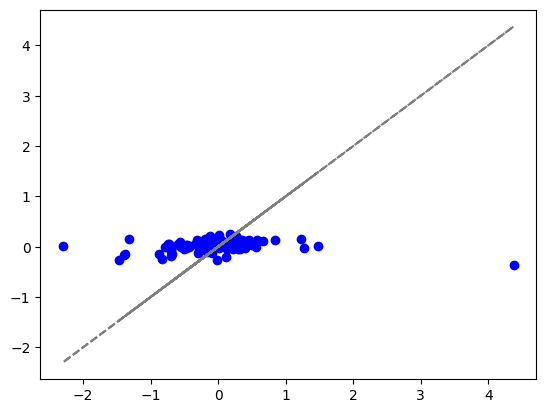

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.impute import SimpleImputer

def prepare_and_train_model(input_filename):
    # Read the data
    data = pd.read_csv(input_filename)
    
    # Ensure 'EWJ.Price.Percent.Today' exists
    if 'EWJ.Price.Percent.Today' not in data.columns:
        print("Error: 'EWJ.Price.Percent.Today' column not found. Run previous analysis first.")
        return None, None, None
    
    # Identify non-numeric columns
    non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns being dropped: {non_numeric_columns}")
    
    # Select only numeric data for imputation and scaling
    numeric_data = data.select_dtypes(include=[np.number])

    # Filter out columns with all missing values
    numeric_data_filtered = numeric_data.dropna(axis=1, how='all')

    # Impute missing values with the column mean (for numeric columns)
    imputer = SimpleImputer(strategy='mean')
    numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data_filtered), columns=numeric_data_filtered.columns)

    
    # Prepare features and target (use only numeric columns)
    X = numeric_data_imputed.drop(['EWJ.Price.Percent.Today'], axis=1)
    y = numeric_data_imputed['EWJ.Price.Percent.Today']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Lasso Regression
    lasso = Lasso(alpha=0.03)
    lasso.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = lasso.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    # Print feature coefficients
    feature_names = X.columns
    coefficients = lasso.coef_
    print("\nFeature Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef}")
    
    #changes scary

    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot(y_test, y_test, color='gray', linestyle='--', label='Perfect Prediction')

    return lasso, scaler, X.columns


prepare_and_train_model("input.engineered.csv")


#A \lambda of 0.0 of course gives us our OLS, all parameters.
#A \lambda of 0.075 reduces our parameters to three, EWJ.High.Minus.Low_lag_0, Tokio_Marine_Holdings.Price.Change_lag_1, Nikkei_225.High.Low.Diff_lag_0
#A \lambda of 0.085 reduces our 85 parameters to one, Nikkei_225.High.Low.Diff yesterday, qualitatively this suggests correction to the mean is predicted as its coeff is negative.


In [25]:
#Poster Graphic Display

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

def prepare_data(input_filename, target_date):
    # Read the data
    data = pd.read_csv(input_filename)
    
    # Convert date column to datetime and handle timezone
    data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
    
    # Convert target_date to timezone-naive datetime
    target_date = pd.to_datetime(target_date).tz_localize(None)
    
    # Split data into training (before target_date) and test (target_date)
    train_data = data[data['Date'] < target_date]
    test_data = data[data['Date'].dt.date == target_date.date()]
    
    if test_data.empty:
        print(f"Warning: No data found for {target_date.date()}, please check the date exists in the dataset")
        print("Available dates:", sorted(data['Date'].dt.date.unique()))
        return None, None, None, None
    
    # Select only numeric data for training
    train_numeric = train_data.select_dtypes(include=[np.number])
    train_numeric_filtered = train_numeric.dropna(axis=1, how='all')
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    train_numeric_imputed = pd.DataFrame(
        imputer.fit_transform(train_numeric_filtered), 
        columns=train_numeric_filtered.columns
    )
    
    # Prepare features and target for training data
    X = train_numeric_imputed.drop(['EWJ.Price.Percent.Today'], axis=1)
    y = train_numeric_imputed['EWJ.Price.Percent.Today']
    
    # Prepare test data
    test_numeric = test_data.select_dtypes(include=[np.number])
    if 'EWJ.Price.Percent.Today' in test_numeric.columns:
        actual_value = test_numeric['EWJ.Price.Percent.Today'].iloc[0]
        test_features = test_numeric.drop(['EWJ.Price.Percent.Today'], axis=1)
    else:
        actual_value = None
        test_features = test_numeric
    
    return X, y, test_features, actual_value

def train_and_predict(X, y, alpha_value, test_date_data):
    # Ensure test data has the same columns as training data
    missing_cols = set(X.columns) - set(test_date_data.columns)
    extra_cols = set(test_date_data.columns) - set(X.columns)
    
    # Remove extra columns from test data
    test_date_data = test_date_data.drop(columns=list(extra_cols), errors='ignore')
    
    # Add missing columns to test data with 0s
    for col in missing_cols:
        test_date_data[col] = 0
        
    # Ensure columns are in the same order
    test_date_data = test_date_data[X.columns]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    test_scaled = scaler.transform(test_date_data)
    
    # Train Lasso Regression
    lasso = Lasso(alpha=alpha_value)
    lasso.fit(X_scaled, y)
    
    # Predict
    prediction = lasso.predict(test_scaled)[0]
    
    return prediction

def plot_predictions(actual_value, predictions, alphas, target_date):
    plt.figure(figsize=(12, 6))
    
    # Plot horizontal line for actual value
    plt.axhline(y=actual_value, color='b', linestyle='-', label='Actual Value')
    
    # Create color map for predictions
    colors = ['lightskyblue', 'cornflowerblue', 'royalblue']
    
    # Plot predictions for different alphas
    for alpha, pred, color in zip(alphas, predictions, colors):
        plt.axhline(y=pred, color=color, linestyle='--', 
                   label=f'Prediction (α={alpha})')
    
    plt.ylabel('EWJ Price Percent Change')
    plt.title(f'Actual vs Predicted EWJ Price Movement for {target_date.date()}\nDifferent Alpha Values Comparison')
    plt.legend()
    plt.grid(True)
    
    # Add value annotations
    plt.text(0.02, actual_value, f'{actual_value:.4f}%', 
             verticalalignment='bottom')
    for pred, color in zip(predictions, colors):
        plt.text(0.02, pred, f'{pred:.4f}%', 
                verticalalignment='bottom', color=color)
    
    # Save the plot
    plt.savefig('predictions_comparison.png', bbox_inches='tight', dpi=300)
    plt.close()

def main(input_filename, target_date='2024-10-25'):
    # Print the target date being analyzed
    print(f"\nAnalyzing data for: {target_date}")
    
    # Prepare data
    X, y, test_data, actual_value = prepare_data(input_filename, target_date)
    if X is None:
        return
    
    # Print feature alignment info
    print("\nFeature alignment check:")
    print(f"Training features: {len(X.columns)}")
    print(f"Test features: {len(test_data.columns)}")
    print("\nMissing features in test data:", 
          set(X.columns) - set(test_data.columns))
    print("\nExtra features in test data:", 
          set(test_data.columns) - set(X.columns))
    
    # Define alpha values
    alphas = [0.0, 0.03, 0.085]
    
    # Get predictions for each alpha
    predictions = []
    print("\nPredictions:")
    for alpha in alphas:
        pred = train_and_predict(X, y, alpha, test_data)
        predictions.append(pred)
        print(f"Alpha {alpha}: {pred:.4f}%")
    
    # Create visualization
    plot_predictions(actual_value, predictions, alphas, pd.to_datetime(target_date))
    print(f"\nActual value: {actual_value:.4f}%")
    print("\nVisualization saved as 'predictions_comparison.png'")

if __name__ == "__main__":
    # You can specify a different date if needed
    main("input.engineered.csv", "2024-10-02")


Analyzing data for: 2024-10-02

Feature alignment check:
Training features: 80
Test features: 84

Missing features in test data: set()

Extra features in test data: {'JPN_10Y_YIELD_lag_10', 'JPN_10Y_YIELD_lag_1', 'JPN_10Y_YIELD_lag_2', 'JPN_10Y_YIELD_lag_0'}

Predictions:
Alpha 0.0: -0.8377%
Alpha 0.03: -0.2427%
Alpha 0.085: -0.0190%


c:\Users\cammi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\cammi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\cammi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.159e+01, tolerance: 1.579e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i


Actual value: 0.1828%

Visualization saved as 'predictions_comparison.png'
